In [68]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    gpu_devices = tf.config.list_physical_devices('GPU')
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    name = details.get('device_name', 'Unknown GPU')
    
    print(f"Using {name}")
else:
    print("No GPU found")

Num GPUs Available:  0
Num CPUs Available:  1
Tensorflow version: 2.10.0
Keras version: 2.10.0
No GPU found


In [70]:
# group images from /data/Thermal Camera Images by class into folders

classes = ["NoGas", "Perfume", "Smoke", "Mixture"]
IMAGE_LENGTH = 640
IMAGE_WIDTH = 480

REORGANIZE_DATA = False

if REORGANIZE_DATA:
    for c in classes:
        if not os.path.exists("data/Thermal Camera Images/" + c):
            os.makedirs("data/Thermal Camera Images/" + c)

    # move images into folders
    # images follow the pattern: "#_class.png"

    # get all .png files in the directory
    files = os.listdir("data/Thermal Camera Images")
    png_files = [f for f in files if f.endswith(".png")]

    # move images into folders
    for f in png_files:
        # get the class of the image
        class_name = f.split("_")[1]
        # remove the .png extension
        class_name = class_name.split(".")[0]
        # move the image into the corresponding folder
        os.rename("data/Thermal Camera Images/" + f, "data/Thermal Camera Images/" + class_name + "/" + f)
        
# function that plots model history
def plot_history(history, name):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy %')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')

    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)

    plt.show()

In [88]:
class MultimodalDataset():
    def __init__(self, data, use_sensors=True, use_images=True):
        # filepaths = data['filepath']
        self.images = data['filepath'].values
        # MQ2 MQ3 MQ5 MQ6 MQ7 MQ8 MQ135
        self.sensor_data = data[['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']].values
        # Gas values
        self.classes = data['Gas'].values
        # if the number of unique classes is not 4, change some
        # this ensure that the dataset return the right sizes even if only a segment of the data is used by lying
        if len(np.unique(self.classes)) != 4:
            self.classes[0] = "Smoke"
            self.classes[1] = "Perfume"
            self.classes[2] = "Mixture"
            self.classes[3] = "NoGas"

        # Gas one-hot encoded
        cat = OneHotEncoder()
        self.labels = cat.fit_transform(self.classes.reshape(-1, 1)).toarray()
        self.use_sensors = use_sensors
        self.use_images = use_images

        if not use_sensors and not use_images:
            raise ValueError("Both use_sensors and use_images cannot be False")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.use_images:
            filepath = self.images[idx]
            image = tf.io.read_file(filepath)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            
            # normalize image
            image = image / 255.0

        sensor_data = self.sensor_data[idx]
        label = self.labels[idx]
        
        if self.use_sensors and self.use_images:
            return (image, sensor_data), label
        elif self.use_sensors:
            return sensor_data, label
        elif self.use_images:
            return image, label
        
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
        
    def get_path(self, idx):
        return self.images[idx]

In [89]:
# load sensor data from data/Gas Sensors Measurements/Gas_Sensor_Measurements.csv
file_data = pd.read_csv("data/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")

# drop the first column
file_data = file_data.drop(columns=["Serial Number"])

# rename Corrosponding Image Name to filename
file_data = file_data.rename(columns={"Corresponding Image Name": "filepath"})

# change the image names from "#_class" to "/data/Thermal Camera Images/class/#_class.png"
file_data["filepath"] = file_data["filepath"].apply(lambda x: "data/Thermal Camera Images/" + x.split("_")[1] + "/" + x + ".png")

# shuffle the data with a seed
file_data = file_data.sample(frac=1, random_state=42)

file_data.head()

,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,filepath
1992,798,527,513,500,679,736,511,Perfume,data/Thermal Camera Images/Perfume/392_Perfume...
2775,812,526,539,524,688,793,589,Perfume,data/Thermal Camera Images/Perfume/1175_Perfum...
4162,720,368,342,365,577,586,302,Smoke,data/Thermal Camera Images/Smoke/962_Smoke.png
5502,516,414,363,340,450,294,398,Mixture,data/Thermal Camera Images/Mixture/702_Mixture...
132,651,526,410,398,635,583,431,NoGas,data/Thermal Camera Images/NoGas/132_NoGas.png


In [90]:
generator = MultimodalDataset(file_data, use_sensors=True, use_images=True)

# get 10 random values from the dataset
for i in range(5):
    data, label = generator[np.random.randint(0, len(generator))]
    print(data[0].shape)
    print(data[1])
    # get the class name from the one-hot encoded label
    print(f'Class: {classes[np.argmax(label)]} label: {label}')
    print()

(640, 480, 3)
[718 528 411 407 638 620 444]
Class: Perfume label: [0. 1. 0. 0.]

(640, 480, 3)
[745 529 392 390 550 556 457]
Class: Smoke label: [0. 0. 1. 0.]

(640, 480, 3)
[702 415 460 420 587 377 427]
Class: NoGas label: [1. 0. 0. 0.]

(640, 480, 3)
[726 534 373 358 474 453 477]
Class: Smoke label: [0. 0. 1. 0.]

(640, 480, 3)
[588 404 376 351 467 275 390]
Class: NoGas label: [1. 0. 0. 0.]



Image shape: (640, 480, 3)


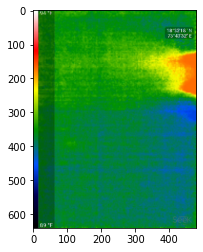

In [91]:
import matplotlib.pyplot as plt
img_path = 'data/Thermal Camera Images/Smoke/1_Smoke.png'

# load image
image = tf.io.read_file(img_path)
image = tf.image.decode_png(image, channels=3)

print(f'Image shape: {image.shape}')

# display image
plt.imshow(image)
plt.show()

In [92]:
# create an image only dataset from all but the last 320 images
image_gen = MultimodalDataset(file_data[:-320], use_sensors=False, use_images=True)
image_dataset = tf.data.Dataset.from_generator(
    image_gen,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

image_dataset = image_dataset.batch(128)
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)
image_dataset = image_dataset.cache()

# create a validation dataset from the next 30 images
val_image_gen = MultimodalDataset(file_data[:320], use_sensors=False, use_images=True)
val_image_dataset = tf.data.Dataset.from_generator(
    val_image_gen,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

val_image_dataset = val_image_dataset.batch(64)
val_image_dataset = val_image_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_image_dataset = val_image_dataset.cache()

In [93]:
# create a simple CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 638, 478, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 319, 239, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 317, 237, 64)      18496     
                                                                 
 dropout_12 (Dropout)        (None, 317, 237, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 158, 118, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 156, 116, 128)    

/home/markbrub/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
history = model.fit(image_dataset, validation_data=val_image_dataset, epochs=10, verbose=1)

Epoch 1/10
48/48 [==============================] - 140s 3s/step - loss: 1.3737 - accuracy: 0.3043 - val_loss: 1.2007 - val_accuracy: 0.4594
Epoch 2/10
48/48 [==============================] - 22s 458ms/step - loss: 1.1200 - accuracy: 0.5418 - val_loss: 0.8599 - val_accuracy: 0.6094
Epoch 3/10
48/48 [==============================] - 22s 458ms/step - loss: 0.7721 - accuracy: 0.6775 - val_loss: 0.5582 - val_accuracy: 0.7719
Epoch 4/10
48/48 [==============================] - 22s 458ms/step - loss: 0.5107 - accuracy: 0.7830 - val_loss: 0.4039 - val_accuracy: 0.8094
Epoch 5/10
48/48 [==============================] - 22s 458ms/step - loss: 0.3976 - accuracy: 0.8258 - val_loss: 0.3609 - val_accuracy: 0.8438
Epoch 6/10
48/48 [==============================] - 22s 458ms/step - loss: 0.3494 - accuracy: 0.8528 - val_loss: 0.3156 - val_accuracy: 0.8687
Epoch 7/10
48/48 [==============================] - 22s 457ms/step - loss: 0.3163 - accuracy: 0.8713 - val_loss: 0.2716 - val_accuracy: 0.9000
E

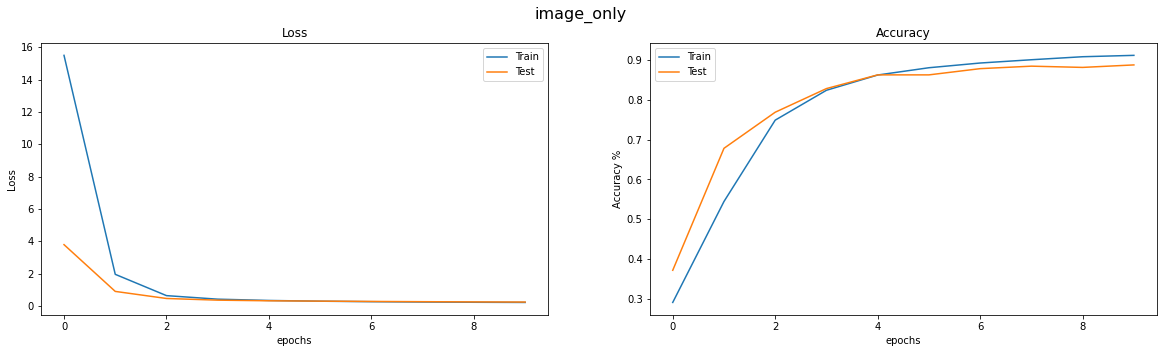

In [94]:
plot_history(history, "image_only")

In [95]:
# create a sensor only dataset from all but the last 320 images
sensor_gen = MultimodalDataset(file_data[:-320], use_sensors=True, use_images=False)
sensor_dataset = tf.data.Dataset.from_generator(
    sensor_gen,
    output_signature=(
        tf.TensorSpec(shape=(7,), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

sensor_dataset = sensor_dataset.batch(256)
sensor_dataset = sensor_dataset.prefetch(tf.data.AUTOTUNE)
sensor_dataset = sensor_dataset.cache()

# create a validation dataset from rest of the images
val_sensor_gen = MultimodalDataset(file_data[:320], use_sensors=True, use_images=False)
val_sensor_dataset = tf.data.Dataset.from_generator(
    val_sensor_gen,
    output_signature=(
        tf.TensorSpec(shape=(7,), dtype=tf.float32),
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

val_sensor_dataset = val_sensor_dataset.batch(64)
val_sensor_dataset = val_sensor_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_sensor_dataset = val_sensor_dataset.cache()

In [135]:
# create a simple MLP
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 128)               1024      
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_79 (Dense)            (None, 64)                8256      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_80 (Dense)            (None, 32)                2080      
                                                                 
 dense_81 (Dense)            (None, 4)                 132       
                                                                 
Total params: 11,492
Trainable params: 11,492
Non-tra

In [136]:
history = model.fit(sensor_dataset, validation_data=val_sensor_dataset, epochs=160, verbose=1)

Epoch 1/160
24/24 [==============================] - 1s 10ms/step - loss: 75.2131 - accuracy: 0.2439 - val_loss: 37.2092 - val_accuracy: 0.2188
Epoch 2/160
24/24 [==============================] - 0s 4ms/step - loss: 41.3070 - accuracy: 0.2439 - val_loss: 18.7298 - val_accuracy: 0.3000
Epoch 3/160
24/24 [==============================] - 0s 5ms/step - loss: 25.6616 - accuracy: 0.2309 - val_loss: 6.4533 - val_accuracy: 0.3500
Epoch 4/160
24/24 [==============================] - 0s 5ms/step - loss: 20.7157 - accuracy: 0.2464 - val_loss: 4.7548 - val_accuracy: 0.3594
Epoch 5/160
24/24 [==============================] - 0s 5ms/step - loss: 17.5734 - accuracy: 0.2799 - val_loss: 3.4235 - val_accuracy: 0.4625
Epoch 6/160
24/24 [==============================] - 0s 4ms/step - loss: 15.7776 - accuracy: 0.3095 - val_loss: 2.3108 - val_accuracy: 0.4594
Epoch 7/160
24/24 [==============================] - 0s 5ms/step - loss: 13.6282 - accuracy: 0.3271 - val_loss: 1.4962 - val_accuracy: 0.4750
Epo

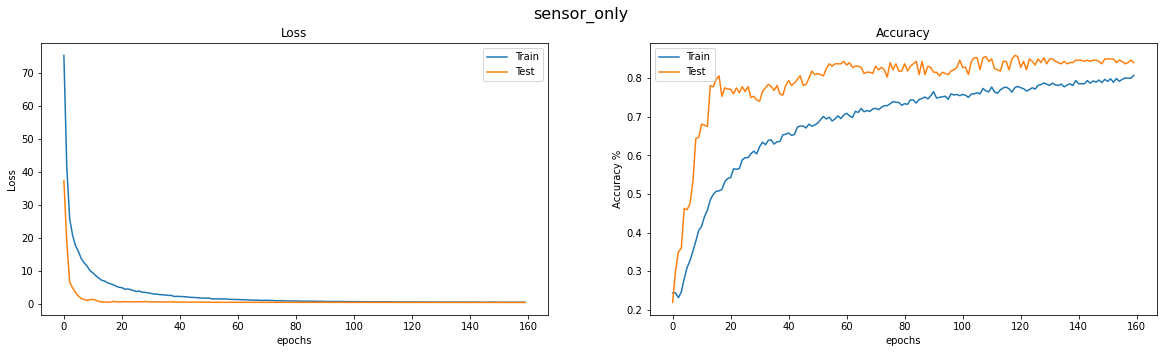

In [137]:
plot_history(history, "sensor_only")

In [ ]:
# create a multimodal dataset from all but the last 320 images
multimodal_gen = MultimodalDataset(file_data[:-320], use_sensors=True, use_images=True)
multimodal_dataset = tf.data.Dataset.from_generator(
    multimodal_gen,
    output_signature=(
        {
            'image': tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
            'sensor': tf.TensorSpec(shape=(7,), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

multimodal_dataset = multimodal_dataset.batch(128)
multimodal_dataset = multimodal_dataset.prefetch(tf.data.AUTOTUNE)
multimodal_dataset = multimodal_dataset.cache()

# create a validation dataset from rest of the images
val_multimodal_gen = MultimodalDataset(file_data[:320], use_sensors=True, use_images=True)
val_multimodal_dataset = tf.data.Dataset.from_generator(
    val_multimodal_gen,
    output_signature=(
        {
            'image': tf.TensorSpec(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), dtype=tf.float32),
            'sensor': tf.TensorSpec(shape=(7,), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(4,), dtype=tf.float32)
    ))

val_multimodal_dataset = val_multimodal_dataset.batch(64)
val_multimodal_dataset = val_multimodal_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_multimodal_dataset = val_multimodal_dataset.cache()

In [ ]:
# create a functional multimodal CNN
image_input = tf.keras.Input(shape=(IMAGE_LENGTH, IMAGE_WIDTH, 3), name='image')
sensor_input = tf.keras.Input(shape=(7,), name='sensor')

image = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(image)
image = tf.keras.layers.MaxPooling2D(2, 2)(image)
image = tf.keras.layers.Flatten()(image)
image = tf.keras.layers.Dense(512, activation='relu')(image)
image = tf.keras.layers.Dense(64, activation='relu')(image)

sensor = tf.keras.layers.Dense(128, activation='relu')(sensor_input)
sensor = tf.keras.layers.Dropout(0.1)(sensor)
sensor = tf.keras.layers.Dense(64, activation='relu')(sensor)
sensor = tf.keras.layers.Dropout(0.05)(sensor)
sensor = tf.keras.layers.Dense(32, activation='relu')(sensor)

concat = tf.keras.layers.concatenate([image, sensor])
output = tf.keras.layers.Dense(4, activation='softmax')(concat)

model = tf.keras.Model(inputs=[image_input, sensor_input], outputs=output)

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(multimodal_dataset, validation_data=val_multimodal_dataset, epochs=160, verbose=1)

In [ ]:
plot_history(history, "multimodal")